In [ ]:
import torch
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=9,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=9,out_channels=3,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=9, padding=4,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,self.idx_key+4]

model1d=cnn1d()

sum(p.numel() for p in model1d.parameters())

1336

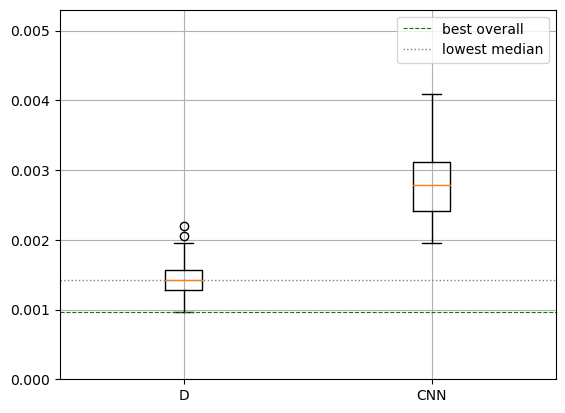

In [1]:
import numpy as np
import matplotlib.pyplot as plt

step = 50
dir1 = "data/example_3_1/loss_arrays/test_cMLP_10hidden"
dir2 = "data/example_3_2/loss_arrays/test_loss_cnn"



def load_loss_arrays(dir, idx, threshold=None):
    l = []
    for k in idx:
        arr = np.load(f"{dir}_{k}.npy")
        if threshold:
            if np.max(arr) < threshold:
                l.append(arr)
        else:
            l.append(arr)
    return np.stack(l, axis = 0)
x = ['D', 'CNN']
boxhidden10 = load_loss_arrays(dir1, np.arange(step), None)
boxcnn = load_loss_arrays(dir2, np.arange(step), None)
boxavg = np.vstack(
    [

        np.min(boxhidden10, axis=1),
        np.min(boxcnn, axis=1)
        ]
    )
bp = plt.boxplot(boxavg.T, labels=x)
lower_whisker_y = bp['whiskers'][0].get_ydata()[1]
lower_median = bp['medians'][0].get_ydata()[0]

plt.axhline(lower_whisker_y, linestyle='--', linewidth=0.8, color='green', label='best overall')
plt.axhline(lower_median, linestyle=':', linewidth=1, color='grey', label='lowest median')

#plt.xlim((0,5))

plt.ylim(0,0.0053)
plt.legend()
plt.grid()

In [133]:
import torch
from torch.utils.data import dataset

from utils.supervised_dataset import supervised_dataset as dataset

class resblock(torch.nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x
    
class transformer_layer(torch.nn.Module):
    def __init__(self, C, num_heads,  MLP_width):
        super().__init__()
    
        self.MHA = torch.nn.MultiheadAttention(embed_dim=C, num_heads=num_heads, batch_first=True, dtype=torch.float32, device='mps')
        self.layernorm1 = torch.nn.LayerNorm(C,  dtype=torch.float32, device='mps')
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(in_features=13,out_features=MLP_width, dtype=torch.float32, device='mps'),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=MLP_width, out_features=MLP_width, dtype=torch.float32, device='mps'),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=MLP_width, out_features=13, dtype=torch.float32, device='mps'),
            torch.nn.ReLU()
        )
        self.layernorm2 = torch.nn.LayerNorm(C, dtype=torch.float32, device='mps')
    def forward(self, x):
        Z = self.layernorm1(self.MHA(x,x,x, need_weights=False)[0])
        return self.layernorm2(self.MLP(Z) + Z)



    
set = dataset(
        input_dir="data/example_3_1/training_set/inputs/", 
        target_dir="data/example_3_1/training_set/target_values/", 
        transform=None, 
        target_transform=None, 
        device='mps'
        )

transformer = transformer_layer(C=13, num_heads=1, MLP_width=128)
x,t = set[0]
x = x[:,1:33,1:33].T.reshape(-1,13)

transformer(x)


tensor([[-0.1068, -1.2093,  0.2063,  ..., -1.1740,  2.0870, -0.1330],
        [-0.1070, -1.2094,  0.2063,  ..., -1.1740,  2.0872, -0.1329],
        [-0.1072, -1.2095,  0.2063,  ..., -1.1741,  2.0873, -0.1328],
        ...,
        [-0.1275, -1.2210,  0.2208,  ..., -1.1774,  2.1018, -0.1250],
        [-0.1277, -1.2211,  0.2208,  ..., -1.1775,  2.1019, -0.1249],
        [-0.1279, -1.2212,  0.2208,  ..., -1.1776,  2.1021, -0.1249]],
       device='mps:0', grad_fn=<NativeLayerNormBackward0>)

In [114]:
from torch import nn
import torch
m = nn.MaxPool2d((2,1))
input = torch.randn(20, 16, 50, 32)
output = m(input)
output.shape

torch.Size([20, 16, 25, 32])

In [108]:
import glob
import os

dir_path = "data/example_3_2/loss_arrays" 


for f in glob.glob(os.path.join(dir_path, "test_loss_cnn_*.npy")):
    os.remove(f)


for f in glob.glob(os.path.join(dir_path, "test_loss_cnnb_*.npy")):
    new_name = os.path.join(
        dir_path,
        os.path.basename(f).replace("test_loss_cnnb_", "test_loss_cnn_")
    )
    os.rename(f, new_name)

In [30]:
import os
from glob import glob

# Path to your directory
directory = "data/example_3_2/loss_arrays"

# List all files
files = os.listdir(directory)

for f in files:
    if f.startswith("test_loss_cnn_") and f.endswith(".npy"):
        print(f)
    if f.startswith("test_loss_cnnb_") and f.endswith(".npy"):
        print(f)

test_loss_cnn_44.npy
test_loss_cnnb_48.npy
test_loss_cnn_7.npy
test_loss_cnn_6.npy
test_loss_cnnb_49.npy
test_loss_cnn_45.npy
test_loss_cnn_47.npy
test_loss_cnn_4.npy
test_loss_cnn_5.npy
test_loss_cnn_46.npy
test_loss_cnn_42.npy
test_loss_cnn_1.npy
test_loss_cnn_0.npy
test_loss_cnn_43.npy
test_loss_cnn_41.npy
test_loss_cnn_2.npy
test_loss_cnn_3.npy
test_loss_cnn_40.npy
test_loss_cnn_27.npy
test_loss_cnn_33.npy
test_loss_cnnb_17.npy
test_loss_cnnb_0.npy
test_loss_cnnb_1.npy
test_loss_cnnb_16.npy
test_loss_cnn_32.npy
test_loss_cnn_26.npy
test_loss_cnnb_28.npy
test_loss_cnn_30.npy
test_loss_cnn_24.npy
test_loss_cnnb_14.npy
test_loss_cnn_18.npy
test_loss_cnnb_3.npy
test_loss_cnnb_2.npy
test_loss_cnn_19.npy
test_loss_cnnb_15.npy
test_loss_cnn_25.npy
test_loss_cnn_31.npy
test_loss_cnnb_29.npy
test_loss_cnnb_11.npy
test_loss_cnn_35.npy
test_loss_cnn_21.npy
test_loss_cnnb_39.npy
test_loss_cnnb_6.npy
test_loss_cnnb_7.npy
test_loss_cnnb_38.npy
test_loss_cnn_20.npy
test_loss_cnn_34.npy
test_loss_